# Get crystal structures Metadata from PDB
- This notebook allows to download a pdb id associated metadata.
- The metadata from the pdb ids belonging to the target protein are gathered into a dataframe named: `TABLA_MTDATA_{prot_name}_{number_of_structures}_crys.json` 

In [1]:
from pathlib import Path
from glob import glob
import pandas as pd
import pickle
import json
import sys
sys.path.insert(0, '../..')
from helper_modules.get_pdb_ids_from_uniport import *

## Protein data

### Inputs
This notebook requires to specify the following values
- `prot_name`: the name of the protein.
- `uniprot_id`: Uniprot Accession number.
- `ref_struc_id`: PDB id of the reference structure.
- `ref_ligand_name`: Three letters name of the cocrystalized ligand in the reference structure.


In [2]:
prot_name       = 'cdk2'
uniprot_id      = 'P24941'
ref_struc_id    = '1fin'
ref_ligand_name = 'ATP'

### Get the protein sequence

In [3]:
seq_prot = get_seq_from_uniprot(uniprot_id)
print(seq_prot)
print(f'\nThere are {len(seq_prot)} residues.')

MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPSTAIREISLLKELNHPNIVKLLDVIHTENKLYLVFEFLHQDLKKFMDASALTGIPLPLIKSYLFQLLQGLAFCHSHRVLHRDLKPQNLLINTEGAIKLADFGLARAFGVPVRTYTHEVVTLWYRAPEILLGCKYYSTAVDIWSLGCIFAEMVTRRALFPGDSEIDQLFRIFRTLGTPDEVVWPGVTSMPDYKPSFPKWARQDFSKVVPPLDEDGRSLLSQMLHYDPNKRISAKAALAHPFFQDVTKPVPHLRL

There are 298 residues.


### Perform a *blastp* over PDB to get all available structures

- <mark>NOTE</mark>: The following steps were done only for CDK2, using [`pypdb`](https://github.com/williamgilpin/pypdb) library which uses the PDB API. However, after November 2020, the PDB API changed and the code shown below does not work (August 2021). In the [FXA]((../../fxa/1_Download_and_prepare_protein_ensembles/2_Get_PDB_structures_metadata.ipynb), [EGFR](../../egfr/1_Download_and_prepare_protein_ensembles/2_Get_PDB_structures_metadata.ipynb), and [HSP90](../../hsp90/1_Download_and_prepare_protein_ensembles/2_Get_PDB_structures_metadata.ipynb) notebooks we followed a different strategy to obtain the protein metadata.

In [4]:
from prody import blastPDB

# Perform a blastp using the UNIPROT sequence
blast_file = f'./{prot_name}_blast_record.pkl'

if Path(blast_file).exists():
    with open(blast_file, 'rb') as file:
        blast_record = pickle.load(file)
else:
    blast_record = blastPDB(seq_prot)
    with open(blast_file, 'wb') as file:
        pickle.dump(blast_record, file)
        
# Get the pdbids of those entries with seq identity >= 95      
pdbids      = blast_record.getHits(percent_identity = 95)
pdbids_list = list(pdbids.keys())
n_pdb_id    = len(pdbids_list)

### Get the available metadata

In [5]:
mtdat_json_file = f"./MTDATA_{prot_name.upper()}_{n_pdb_id}_crys.json"

# If the dictionary already exists, load it!
if Path(mtdat_json_file).exists():
    with open(mtdat_json_file, 'r') as file:
        prot_crys_mtd_dict = json.load(file)
# If it does't exist, create it
else:  
    # Create an empty dict to fill it with the pdbs metadata
    prot_crys_mtd_dict = {}
    for pdb_id in pdbids_list:
        # Get the metadata using pypdb
        descrip_pdb = pypdb.describe_pdb(pdb)
        cristal = pypdb.get_entity_info(pdb)
        ligando = pypdb.get_ligands(pdb)['ligandInfo']
        secuencia = pdbids[pdb]
        # Find number of gaps and coverage 
        # with regards the Uniprot sequence
        seq_alg, coverage, gaps = get_gaps_and_coverage(
                                    pdb_file = f'{pdb_id}', 
                                    full_sequence = seq_prot,
                                    chain = 'A')
        if ligando:
            ligando = ligando['ligand']
            if isinstance(ligando, dict): 
                # If it returns a dictionary, 
                # there will be only one ligand
                ligando = [ligando]
            num_ligs = len(ligando)
            # Create a list with the name of the ligands
            ligs_names = [ligando[mol]['@chemicalID'] 
                          for mol in range(num_ligs)]
        else:
            ligs_names = []
            num_ligs = 0
        prot_crys_mtd_dict.update(
            {pdb : 
                 {'describe_pdb': descrip_pdb, 
                  'pdb_info': cristal, 
                  'ligs': ligando,       
                  'num_ligs': num_ligs, 
                  'name_ligs': ligs_names,
                  'seq': secuencia,
                  'seq_alg': seq_alg, 
                  'coverage': covertura,
                  'gaps': gaps
                 }
            })
    # Save the dict as a json file
    with open(mtdat_json_file, 'w') as file:
        json.dump(file, prot_crys_mtd_dict)

#### Visualize the `1FIN` entry metadata
- Just an example of the metadata retrieved for a given pdb id. This example is not shown in the EGFR and HSP90 notebooks.

In [6]:
prot_crys_mtd_dict[ref_struc_id]

{'describe_pdb': {'structureId': '1FIN',
  'title': 'CYCLIN A-CYCLIN-DEPENDENT KINASE 2 COMPLEX',
  'pubmedId': '7630397',
  'expMethod': 'X-RAY DIFFRACTION',
  'resolution': '2.30',
  'keywords': 'COMPLEX (TRANSFERASE/CYCLIN)',
  'nr_entities': '2',
  'nr_residues': '1116',
  'nr_atoms': '9060',
  'deposition_date': '1996-07-14',
  'release_date': '1997-01-27',
  'last_modification_date': '2011-07-13',
  'structure_authors': 'Jeffrey, P.D., Russo, A.A., Pavletich, N.P.',
  'citation_authors': 'Jeffrey, P.D., Russo, A.A., Polyak, K., Gibbs, E., Hurwitz, J., Massague, J., Pavletich, N.P.',
  'status': 'CURRENT'},
 'pdb_info': {'Method': {'@name': 'xray'},
  'Entity': [{'@id': '1',
    '@type': 'protein',
    'Chain': [{'@id': 'A'}, {'@id': 'C'}]},
   {'@id': '2', '@type': 'protein', 'Chain': [{'@id': 'B'}, {'@id': 'D'}]}],
  'structureId': '1fin',
  'bioAssemblies': '2',
  'release_date': 'Mon Jan 27 00:00:00 PST 1997',
  'resolution': '2.30'},
 'ligs': [{'@structureId': '1FIN',
   '@ch

## Create the final Metadata table

In [7]:
def get_data_rows(pdb_entry: dict) -> pd.Series:
    '''
    This function takes a pdb_entry dictionary, 
    nested in `prot_crys_mtd_dict` created in the previous cell,
    and returns a pandas series containing the entry metadata
    '''
    e = pdb_entry
    d = e['describe_pdb']
    s = e['seq']
    l = e['ligs']

    dic = {"PDB_ID"    : d['structureId'].lower(),
          "Title"      : d['title'].lower(),
          "Entities"   : d['nr_entities'],
          "ChainID"    : s['chain_id'],
          "Identity"   : s['identity'],
          "Coverage"   : e['covertura'],
          "NumGaps"    : e['gaps']['num_gaps'],
          "GapLen"     : e['gaps']['gap_lengths'],
          "GapPos"     : e['gaps']['gap_list'],
          "Resolution" : d['resolution'],
          "Date"       : d['release_date'],
          "NumLigs"    : e['num_ligs'], 
          "NameLigs"   : e['name_ligs']
          }
    entry_series = pd.Series(dic)
    return entry_series

def get_mtd_table(dic: dict):
    '''
     This function is designed to take the 
     `prot_crys_mtd_dict` dictionary
     and extract a pandas series for each pdb entry
    '''
    df = pd.DataFrame()
    for pdb_id in dic.keys():
        row = get_data_rows(dic[pdb_id])
        df = df.append(row, ignore_index=True)
    return df

In [8]:
# Now we create the dataframe
df_prot = get_mtd_table(prot_crys_mtd_dict).sort_values("PDB_ID").set_index("PDB_ID")

# The following pdb strucutes were not considered as during modelling
# these structures gave unuseful structures or errors
droped_pdb_ids = [
    "5ang", "4ek6", 
    "6ath", "5uq3",
    "1jsu", "5mhq"]
df_prot = df_prot.drop(droped_pdb_ids, axis = 0)

# Reorder the columns
df_prot = df_prot[['Title','Date', 'Entities', 'ChainID','Resolution', 
         'Identity', 'Coverage', 'NumGaps', 'GapLen', 'GapPos',
         'NumLigs', 'NameLigs']]
df_prot.head()

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs
PDB_ID,,,,,,,,,,,,
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.00,298.0,92.953020,2.0,"[9, 14]","[[36, 44], [149, 162]]",1.0,[STU]
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.00,298.0,97.315436,1.0,[9],"[[36, 44]]",3.0,"[ACE, ATP, MG]"
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.10,298.0,97.315436,1.0,[9],"[[36, 44]]",3.0,"[ACE, ATP, MG]"
1buh,crystal structure of the human cdk2 kinase com...,1998-09-09,2,A,2.60,298.0,96.308725,2.0,"[8, 5]","[[40, 47], [295, 299]]",0.0,[]
1ckp,human cyclin dependent kinase 2 complexed with...,1999-01-13,1,A,2.05,298.0,93.624161,2.0,"[9, 12]","[[36, 44], [153, 164]]",2.0,"[EDO, PVB]"


## Save the metadata Dataframe to a file

In [9]:
n_pdb_id_to_use = len(df_prot)
dataframe_file = f"./TABLA_MTDATA_{prot_name.upper()}_{n_pdb_id_to_use}_crys.json"
if not Path(dataframe_file).exists:
    df_prot.to_json(dataframe_file)

## Data exploration

In [10]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1.2, style = 'white')

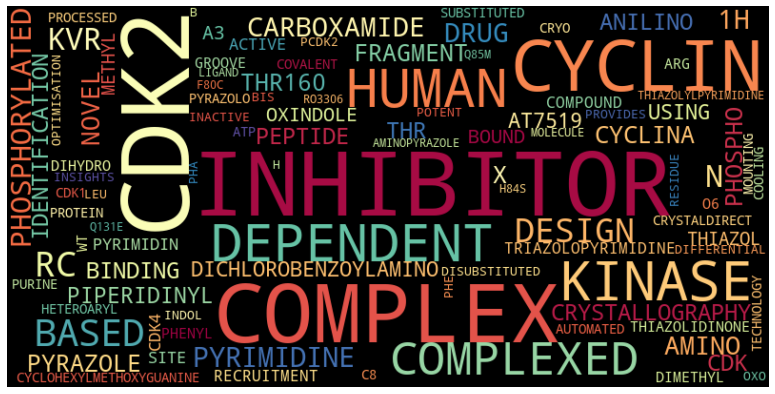

In [11]:
text = " ".join(titulo for titulo in df_prot.Title)
text = text.replace('-', ' ').upper()

stopwords = set(STOPWORDS)
stopwords.update([ "structure", "ray", "crystal", "yl"])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = stopwords, 
                      max_font_size = 100, 
                      collocations = False, 
                      min_font_size = 4,
                      contour_width = 100, 
                      colormap = "Spectral", 
                      random_state = 15,
                      max_words = 100, 
                      width=800, height=400,
                      background_color = "black").generate(text)

plt.figure(figsize = (16, 7))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [12]:
def plot_property(prop, color = 'red', title = ''):
    df_prot[prop] = df_prot[prop].astype(float)
    fig, ax = plt.subplots(figsize = (8, 5))
    sns.histplot(df_prot[prop] , 
                 color = color, 
                 kde = True,
                 label = prop,
                 ax = ax)
    plt.legend()
    plt.title(title)
    plt.show()

[Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Number of structures published by year')]

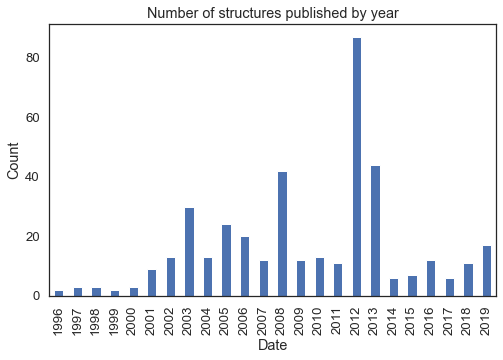

In [13]:
df_prot.Date = pd.to_datetime(df_prot.Date)
df_prot_dates = df_prot.set_index('Date')
df_prot_dates.tail()
fig, ax = plt.subplots(figsize = (8, 5))
ax = df_prot.groupby(df_prot.Date.dt.year)['Date'].count().plot(kind='bar')
ax.set(ylabel = 'Count', title = 'Number of structures published by year')

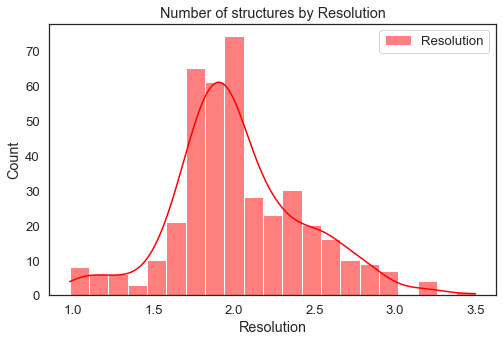

In [14]:
prop = 'Resolution'
plot_property(prop, title = f'Number of structures by {prop}')

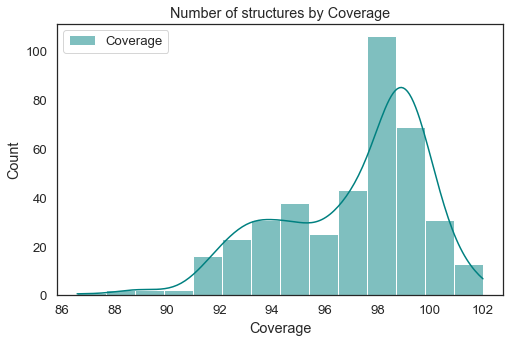

In [15]:
prop = 'Coverage'
plot_property(prop, color = 'teal',
             title = f'Number of structures by {prop}')

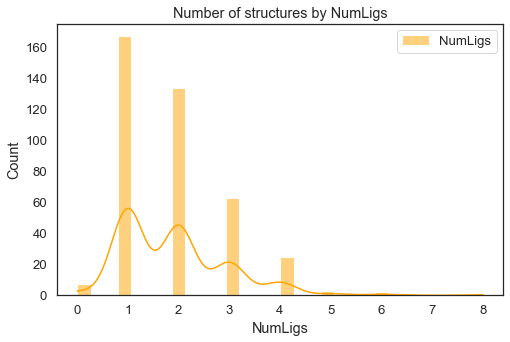

In [16]:
prop = 'NumLigs'
plot_property(prop, color = 'orange',
              title = f'Number of structures by {prop}')